In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
dfInit = pd.read_csv('../docs/stroke_data.csv', delimiter=',', encoding='utf-8')
df = dfInit.copy(deep=True)
display(df)

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
0,66.788137,Male,Medium,1,0,25.842521,96.428681,1,Current,1
1,86.393609,Female,Medium,1,1,32.531061,133.350068,0,Never,1
2,76.158579,Female,Medium,1,0,40.681244,111.489589,0,Never,0
3,72.477870,Female,Low,0,1,33.003193,125.692465,0,Former,0
4,59.881635,Male,Low,0,0,26.062443,123.218486,1,Never,1
...,...,...,...,...,...,...,...,...,...,...
9995,80.647182,Female,Medium,1,1,28.283629,128.639802,0,Former,1
9996,82.607321,Female,Medium,1,1,31.148301,105.025226,1,Current,1
9997,86.020702,Female,High,1,1,32.641037,147.174095,0,Never,1
9998,67.387542,Female,Medium,0,1,29.946547,112.480515,0,Former,0


In [3]:
genderDict = {'Male': 0, 'Female': 1}
sesDict = {'Medium': 0, 'Low': 1, 'High': 2}
smokingDict = {'Current': 0, 'Never': 1, 'Former' : 2}

df["Gender"] = df["Gender"].map(lambda x: genderDict[x])
df["Smoking_Status"] = df["Smoking_Status"].map(lambda x: smokingDict[x])
df["SES"] = df["SES"].map(lambda x: sesDict[x])
display(df)

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
0,66.788137,0,0,1,0,25.842521,96.428681,1,0,1
1,86.393609,1,0,1,1,32.531061,133.350068,0,1,1
2,76.158579,1,0,1,0,40.681244,111.489589,0,1,0
3,72.477870,1,1,0,1,33.003193,125.692465,0,2,0
4,59.881635,0,1,0,0,26.062443,123.218486,1,1,1
...,...,...,...,...,...,...,...,...,...,...
9995,80.647182,1,0,1,1,28.283629,128.639802,0,2,1
9996,82.607321,1,0,1,1,31.148301,105.025226,1,0,1
9997,86.020702,1,2,1,1,32.641037,147.174095,0,1,1
9998,67.387542,1,0,0,1,29.946547,112.480515,0,2,0


In [4]:
X = df.drop('Stroke', axis=1).values
y = df['Stroke'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
feature_len = X_scaled.shape[1]
side_len = int(np.ceil(np.sqrt(feature_len)))
padding = side_len ** 2 - feature_len
X_padded = np.pad(X_scaled, ((0, 0), (0, padding)), 'constant')
X_reshaped = X_padded.reshape(-1, 1, side_len, side_len)
display(X_reshaped)

array([[[[-0.30091375, -1.00742758, -0.87999831],
         [ 0.80666586, -0.65902099, -0.44881679],
         [-0.77265462,  2.02534955, -1.55986422]]],


       [[[ 1.68566282,  0.99262718, -0.87999831],
         [ 0.80666586,  1.51740236,  0.91586318],
         [ 1.47586338, -0.49374193,  0.01178739]]],


       [[[ 0.64857122,  0.99262718, -0.87999831],
         [ 0.80666586, -0.65902099,  2.57876593],
         [ 0.14455696, -0.49374193,  0.01178739]]],


       ...,


       [[[ 1.64787703,  0.99262718,  1.66408469],
         [ 0.80666586,  1.51740236,  0.93830198],
         [ 2.31774864, -0.49374193,  0.01178739]]],


       [[[-0.24017739,  0.99262718, -0.87999831],
         [-1.23967067,  1.51740236,  0.38853817],
         [ 0.20490446, -0.49374193,  1.58343899]]],


       [[[-0.76874203, -1.00742758,  1.66408469],
         [-1.23967067, -0.65902099,  0.81863529],
         [-1.9269906 , -0.49374193,  0.01178739]]]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
class StrokeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * (side_len // 2) * (side_len // 2), 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StrokeCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, loss: {total_loss:.4f}")

Epoch 1, loss: 127.6072
Epoch 2, loss: 110.6119
Epoch 3, loss: 108.8278
Epoch 4, loss: 107.9480
Epoch 5, loss: 107.3739
Epoch 6, loss: 106.8482
Epoch 7, loss: 106.5519
Epoch 8, loss: 106.1636
Epoch 9, loss: 105.8739
Epoch 10, loss: 105.8074
Epoch 11, loss: 105.6192
Epoch 12, loss: 105.6518
Epoch 13, loss: 105.3075
Epoch 14, loss: 105.0987
Epoch 15, loss: 105.1576


In [10]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        pred_labels = pred.argmax(dim=1)
        correct += (pred_labels == yb).sum().item()
        total += yb.size(0)
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print(f"Accuracy : {correct / total:.4f}")

Accuracy : 0.7970


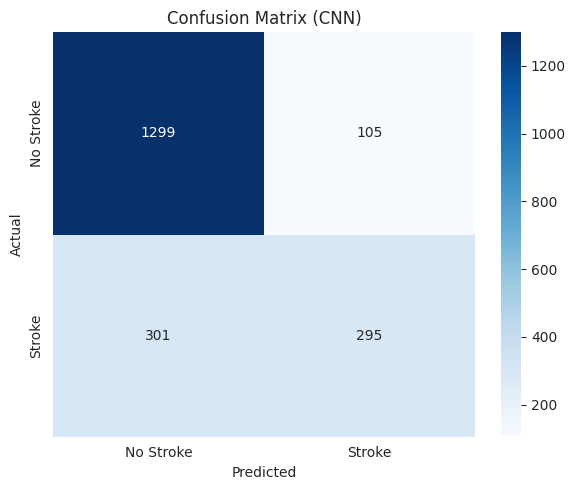

In [11]:
cm = confusion_matrix(all_labels, all_preds)

class_names = ['No Stroke', 'Stroke']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CNN)')
plt.tight_layout()
plt.show()